In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import pyro
import scipy as sp
import scipy.stats
import time
import torch
import yaml
try:
    from yaml import CLoader as Loader
except ImportError:
    from yaml import Loader

In [2]:
# These scenes include uniformly randomly distributed nonpenetrating
# object arrangements
DATA_FILE = "data/20181127_uniform_feasible_1_box_1000/20181207_uniform_feasible_1_box_1000.yaml"
# These loaded scenes include squares on the left half of the scene, and
# long rectangles on the right half of the scene. All objects
# tend to lie along cardinal directions (theta = 0, pi/2, pi, ...)
#DATA_FILE = "data/20180709_sorted_grid_10000.yaml"

with open(DATA_FILE, "r") as f:
    environments = yaml.load(f, Loader=Loader)
    N_ENVIRONMENTS = len(environments.keys())
    print("Loaded %d environments from file %s" % (N_ENVIRONMENTS, DATA_FILE))
environments = [environments[key] for key in environments.keys()]

Loaded 1000 environments from file data/20181127_uniform_feasible_1_box_1000/20181207_uniform_feasible_1_box_1000.yaml


Selection of environments from original distribution


/home/gizatt/miniconda2/envs/py27/lib/python2.7/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


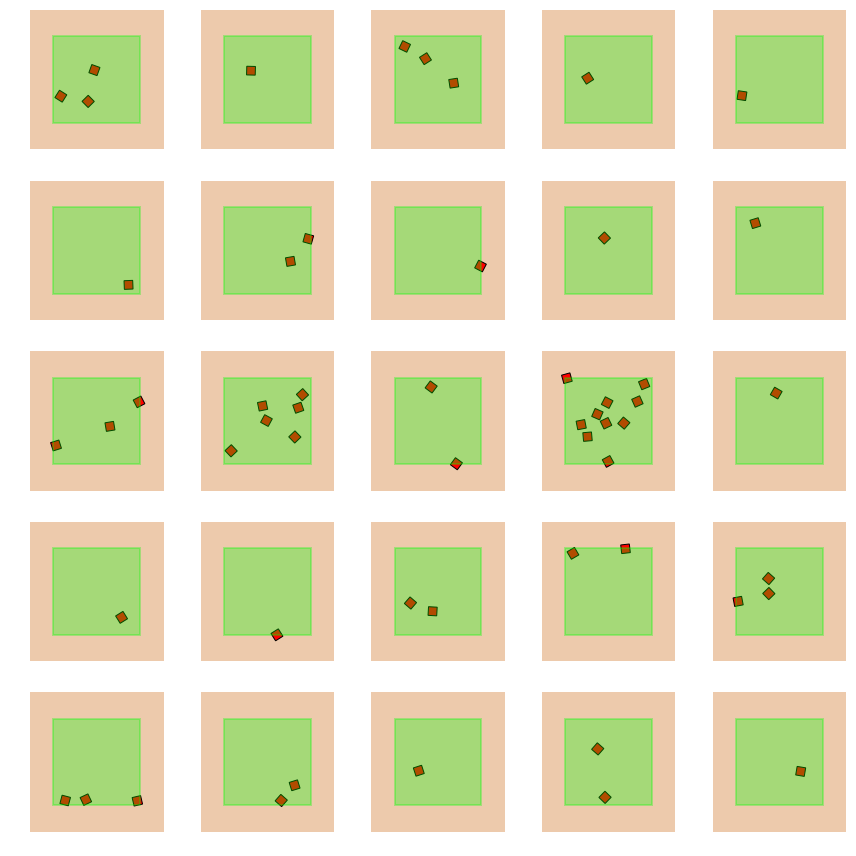

In [3]:
# Illustrate a few example scenes from the training set
import generate_planar_scene_arrangements as psa_utils

def draw_environment(environment, ax):
    rbt, q = psa_utils.build_rbt_from_summary(environment)
    psa_utils.draw_board_state(ax, rbt, q)
    
    patch = patches.Rectangle([0., 0.], 1., 1., fill=True, color=[0., 1., 0.], 
                              linestyle='solid', linewidth=2, alpha=0.3)
    ax.add_patch(patch)

plt.figure().set_size_inches(12, 12)
print "Selection of environments from original distribution"
N = 5
for i in range(N):
    for j in range(N):
        plt.subplot(N, N, i*N+j+1)
        draw_environment(environments[i*N+j], plt.gca())
        plt.grid(True)
plt.tight_layout()

Write our generator in Pyro, as an iterative procedure:

~~~python
keep_going = True
# Spawn the first object with no context -- in our case,
# this is placing a hard-coded ground object.
env = spawn_initial_object()
while (keep_going):
    # Pick an object to spawn
    ci = sample_object_class(env)
    # Pick where to put it
    env = sample_object_placement(ci, env)
    # Make that placement feasible
    env = project_env_to_feasibility(env)
    keep_going = decide_to_continue(env)
~~~

In [15]:
from collections import namedtuple
import torch
import pyro
import pyro.infer
import pyro.optim
import pyro.distributions as dist
from pyro import poutine
from pyro.optim import Adam
from pyro.infer import SVI, TraceEnum_ELBO, config_enumerate
#torch.manual_seed(101);

pyro.enable_validation(True)

object_classes = ["small_box"]
object_class_to_index = {}
for i, obj in enumerate(object_classes):
    object_class_to_index[obj] = i
n_object_classes = len(object_classes)


def sample_object_class(generated_data, i, keep_going, obs=None):
    # For now, single object class, so this is trivial.
    # Down the road, the category probs will need to depend on env
    # in some way.
    return poutine.mask(lambda: pyro.sample("%d_class_assignment" % i,
                        dist.Categorical(torch.Tensor([1.0])),
                        obs=obs), keep_going)()

# Prior distributions for each object class over the ground
class ObjectWorldPriorDescription:
    def __init__(self, ci):
        self.num_modes = 4
        with pyro.plate("c%d_modes" % ci, self.num_modes):
            self.centers = pyro.sample(
                'c%d_centers' % ci,
                 dist.MultivariateNormal(torch.Tensor([0.5, 0.5, 3.14]),
                                         torch.diag(torch.Tensor([0.5, 0.5, 3.14]))))
            self.widths = pyro.sample(
                'c%d_widths' % ci,
                 dist.LogNormal(0.25, 0.5).expand([3]).to_event(1))

    def vectorize():
        raise NotImplementedError()
        return torch.Tensor([])

def sample_object_placement(ci, generated_data, i, keep_going, object_world_prior_params, obs=None):
    # TODO: figure out how to do a broadcast-select of this.
    # I could use index_select if I stacked the params into a Tensor,
    # I just need to abandon my nice data structure...
    prior_info = object_world_prior_params[0]
    
    # Evenly weighted mixture of gaussians
    assignment = pyro.sample('assignment_%d' % (i), dist.Categorical(torch.ones(prior_info.num_modes)),
                             infer = {"enumerate": "parallel"})
    orig_assignment_shape = assignment.shape
    selected_centers = torch.index_select(
        prior_info.centers, 0, assignment.flatten()).view(
            orig_assignment_shape + (3, ))
    selected_widths = torch.index_select(
        prior_info.widths, 0, assignment.flatten()).view(
            orig_assignment_shape + (3,))
    diagonalized_selected_widths = torch.diag_embed(selected_widths)
    
    location = poutine.mask(lambda:
            pyro.sample('location_%d' % (i),
                        dist.MultivariateNormal(
                            selected_centers,
                            diagonalized_selected_widths),
                        obs=obs),
            keep_going)()
    return location

MAX_NUM_OBJECTS = 10    
def sample_keep_going(generated_data, i, falloff_rate, obs=None):
    return pyro.sample('keep_going_%d' % i,
                        dist.Bernoulli(falloff_rate),
                        obs=obs)

VectorizedEnvironments = namedtuple("VectorizedEnvironments",
    ["idents", "poses", "present", "n_samples"], verbose=False)
def vectorize_environments(envs):
    # Vectorization into a 
    # poses (order x y theta) and
    # idents (ci) per object
    n_environments = len(envs)
    poses = torch.Tensor(n_environments, MAX_NUM_OBJECTS*3)
    poses[:, :] = 0.
    idents = torch.LongTensor(n_environments, MAX_NUM_OBJECTS)
    idents[:, :] = 0
    present = torch.Tensor(n_environments, MAX_NUM_OBJECTS)
    present[:, :] = 0
    n_samples = torch.Tensor(n_environments)
    n_samples[:] = 0
    for i, env in enumerate(envs):
        n_samples[i] = env["n_objects"]
        for k in range(MAX_NUM_OBJECTS):
            if k < env["n_objects"]:
                obj = env["obj_%04d" % k]
                idents[i, k] = object_class_to_index[obj["class"]]
                poses[i, (k*3):(k*3+3)] = torch.Tensor(obj["pose"])
                present[i, k] = 1
    return VectorizedEnvironments(
        idents=idents, poses=poses,
        present=present, n_samples=n_samples)
    
def devectorize_environments(data):
    if not isinstance(data, VectorizedEnvironments):
        raise ValueError("Expected VectorizedEnvironments input")
    envs = []
    for i in range(data.idents.shape[0]):
        env = {}
        n_objects = 0
        for k in range(data.n_samples[i]):
            obj = {
                "pose": data.poses[i, (k*3):(k*3+3)].cpu().detach().numpy(),
                "class": object_classes[data.idents[i, k].cpu().detach().item()]
            }
            env["obj_%04d" % k] = obj
        env["n_objects"] = data.n_samples[i]
        envs.append(env)
    return envs

# Each row of "data" is a vectorized
# description of an environment.
# To make these rows constant size, all vectorizations
# are the same length, but padded with "null objects"
# up to a max number of objects. This is inspired by
# the handling of the Pyro AIR example.

def model(data=None, batch_size=None):
    i = 0
    keep_going = True
    
    object_world_prior_params = []
    for i in range(n_object_classes):
        object_world_prior_params.append(
            ObjectWorldPriorDescription(i)
        )
        
    sample_rates = pyro.sample('num_objects_weights', dist.Dirichlet(torch.ones(MAX_NUM_OBJECTS+1)))
    sample_distribution = dist.Categorical(sample_rates)
    
    # Generate in vectorized form for easier batch conversion at the end
    n = 1
    if data:
        if not isinstance(data, VectorizedEnvironments):
            raise ValueError("Expected VectorizedEnvironments input")
        if (data.idents.shape[1] != MAX_NUM_OBJECTS and
           data.poses.shape[1] != MAX_NUM_OBJECTS*3):
            raise ValueError("Got unexpected data shape.")
        n = data.idents.shape[0]
    if batch_size is None:
        batch_size = n
    with pyro.plate('data', n, subsample_size=batch_size) as ind:
        generated_data = VectorizedEnvironments(
            idents=torch.LongTensor(batch_size, MAX_NUM_OBJECTS),
            poses=torch.Tensor(batch_size, MAX_NUM_OBJECTS*3),
            present=torch.Tensor(batch_size, MAX_NUM_OBJECTS),
            n_samples=torch.Tensor(batch_size))
        generated_data.idents[:, :] = -1
        generated_data.poses[:, :] = 0
        generated_data.present[:, :] = 0
        generated_data.n_samples[:] = 0

        # Sample actual number of samples immediately
        gt_n_samples = None
        if data is not None:
            gt_n_samples = data.n_samples[ind]
        num_samples = pyro.sample("num_samples", sample_distribution,
                                  obs=gt_n_samples)
        generated_data.n_samples[:] = num_samples
        
        for i in range(MAX_NUM_OBJECTS):
            gt_class = None
            gt_location = None
            gt_keep_going = None
            if data is not None:
                gt_class = data.idents[ind, i]
                gt_location = data.poses[ind, (i*3):(i*3+3)]
                gt_keep_going = data.present[ind, i]
                
            keep_going = (i < num_samples)
            ci = sample_object_class(generated_data, i, keep_going, gt_class)
            location = sample_object_placement(ci, generated_data, i, keep_going, object_world_prior_params, gt_location)
            
            # Fill in generated data appropriately
            generated_data.idents[:, i] = ci.view(-1).type(torch.long)*keep_going.type(torch.long)
            for k in range(3):
                generated_data.poses[:, 3*i+k] = torch.Tensor(location[..., k])*keep_going.type(torch.float)
            generated_data.present[:, i] = keep_going.type(torch.float)
            #skip feasibility project for first pass
    return generated_data

print model()

VectorizedEnvironments(idents=tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]), poses=tensor([[ 1.2672,  0.1775,  5.3562, -0.2243, -0.0079,  6.6590,  0.2933, -0.6272,
          4.0891, -1.8148, -0.9306,  4.0539,  0.0000, -0.0000,  0.0000, -0.0000,
         -0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000]]), present=tensor([[1., 1., 1., 1., 0., 0., 0., 0., 0., 0.]]), n_samples=tensor([4.]))


Selection of environments from prior / generative model


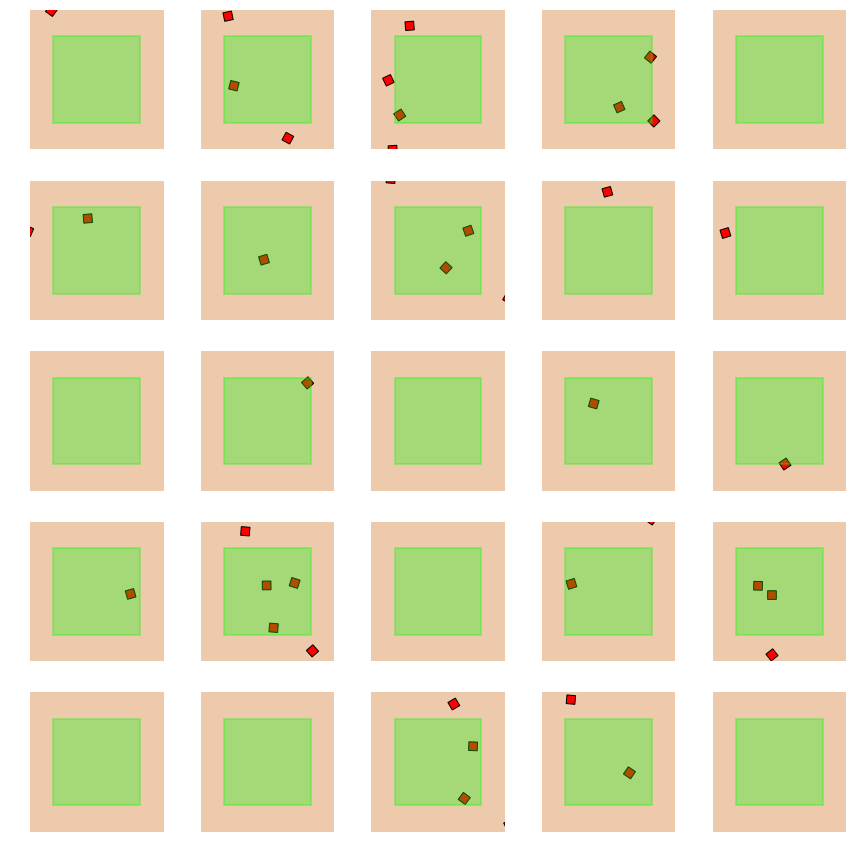

In [11]:
plt.figure().set_size_inches(12, 12)
print "Selection of environments from prior / generative model"
N = 5

for i in range(N):
    for j in range(N):
        plt.subplot(N, N, i*N+j+1)
        draw_environment(devectorize_environments(model())[0], plt.gca())
        plt.grid(True)
plt.tight_layout()

In [20]:
# Rig for SVI.
from collections import defaultdict
from torch.distributions import constraints
from pyro.infer import Trace_ELBO
from pyro.contrib.autoguide import AutoDelta, AutoDiagonalNormal, AutoMultivariateNormal

pyro.enable_validation(True)

global_guide = AutoDelta(
    poutine.block(model, expose=[
        'num_objects_weights', 'c0_centers', 'c0_widths']))
optim = pyro.optim.Adam({'lr': 0.1, 'betas': [0.8, 0.99]})
elbo = TraceEnum_ELBO(max_plate_nesting=2)
svi = SVI(model, global_guide, optim, loss=elbo)

def initialize(seed):
    pyro.set_rng_seed(seed)
    pyro.clear_param_store()
    pyro.param('auto_num_objects_weights', torch.ones(MAX_NUM_OBJECTS+1)/float(MAX_NUM_OBJECTS+1), constraint=constraints.simplex)
    #pyro.param('auto_c0_centers', torch.Tensor([0.5, 0.5, 1.57]))
    #pyro.param('auto_c0_halfwidth', torch.Tensor([1.0, 1.0, 4.0]))

# Choose the best among 100 random initializations.
#initialize(42)

losses = []
data = vectorize_environments(environments)
for i in range(101):
    loss = svi.step(data, 100)
    losses.append(loss)
    if (i % 10 == 0):
        print ".",
    if (i % 100 == 0):
        print "\n"
        print global_guide.median()
print "Done"

. 

{'num_objects_weights': tensor([3.6548e-09, 6.0718e-01, 2.2591e-01, 9.9903e-02, 3.8935e-02, 1.5754e-02,
        8.9931e-03, 3.1090e-03, 5.9459e-10, 7.9470e-10, 2.2130e-04],
       grad_fn=<ExpandBackward>), 'c0_widths': tensor([[0.0835, 0.0782, 1.4408],
        [0.1103, 0.0894, 0.3977],
        [0.0924, 0.0746, 0.3378],
        [0.0835, 0.0782, 1.4403]], grad_fn=<ExpandBackward>), 'c0_centers': tensor([[0.4005, 0.5444, 3.0084],
        [0.4999, 0.6494, 1.0256],
        [0.4236, 0.4136, 5.5297],
        [0.4007, 0.5439, 3.0079]], grad_fn=<ExpandBackward>)}
. . . . . . . . . . 

{'num_objects_weights': tensor([1.0969e-10, 5.6494e-01, 2.3543e-01, 1.2368e-01, 4.5359e-02, 1.5738e-02,
        9.8733e-03, 3.9508e-03, 1.9477e-11, 2.5380e-11, 1.0329e-03],
       grad_fn=<ExpandBackward>), 'c0_widths': tensor([[0.0934, 0.0935, 1.0673],
        [0.0947, 0.0949, 0.2771],
        [0.0832, 0.0809, 0.2914],
        [0.0935, 0.0936, 1.0671]], grad_fn=<ExpandBackward>), 'c0_centers': tensor([[0.501

{'num_objects_weights': tensor([1.0969e-10, 5.6494e-01, 2.3543e-01, 1.2368e-01, 4.5359e-02, 1.5738e-02,
        9.8733e-03, 3.9508e-03, 1.9477e-11, 2.5380e-11, 1.0329e-03],
       grad_fn=<ExpandBackward>), 'c0_widths': tensor([[0.0934, 0.0935, 1.0673],
        [0.0947, 0.0949, 0.2771],
        [0.0832, 0.0809, 0.2914],
        [0.0935, 0.0936, 1.0671]], grad_fn=<ExpandBackward>), 'c0_centers': tensor([[0.5013, 0.5401, 3.1016],
        [0.4433, 0.4988, 0.8651],
        [0.5121, 0.4626, 5.4245],
        [0.5039, 0.5380, 3.1002]], grad_fn=<ExpandBackward>)}


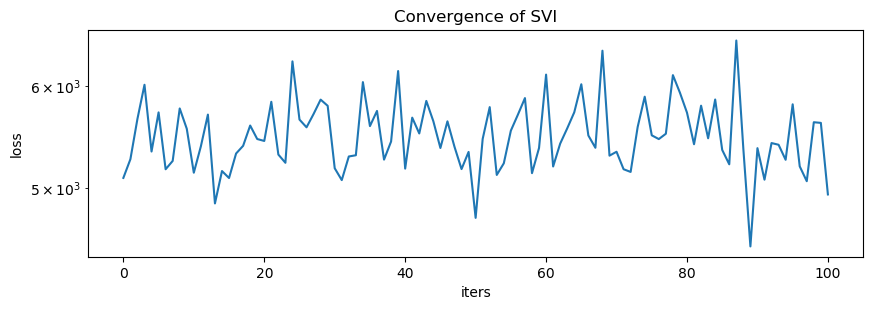

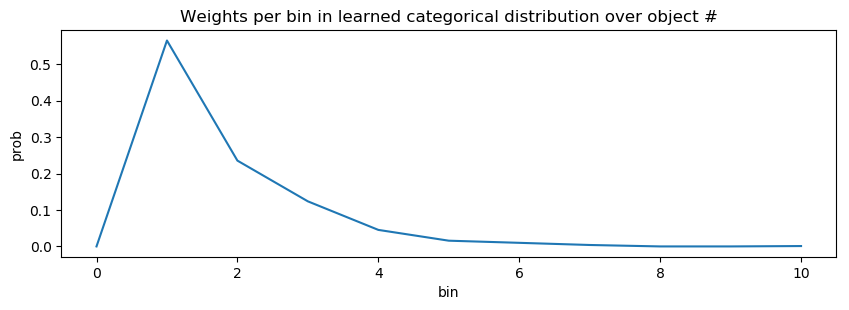

In [21]:
plt.figure(figsize=(10,3), dpi=100).set_facecolor('white')
plt.plot(losses)
plt.xlabel('iters')
plt.ylabel('loss')
plt.yscale('log')
plt.title('Convergence of SVI');
print global_guide.median()

plt.figure(figsize=(10,3), dpi=100).set_facecolor('white')
plt.plot(global_guide.median()["num_objects_weights"].cpu().detach().numpy())
plt.xlabel('bin')
plt.ylabel('prob')
plt.title('Weights per bin in learned categorical distribution over object #');

Selection of environments from prior / generative model


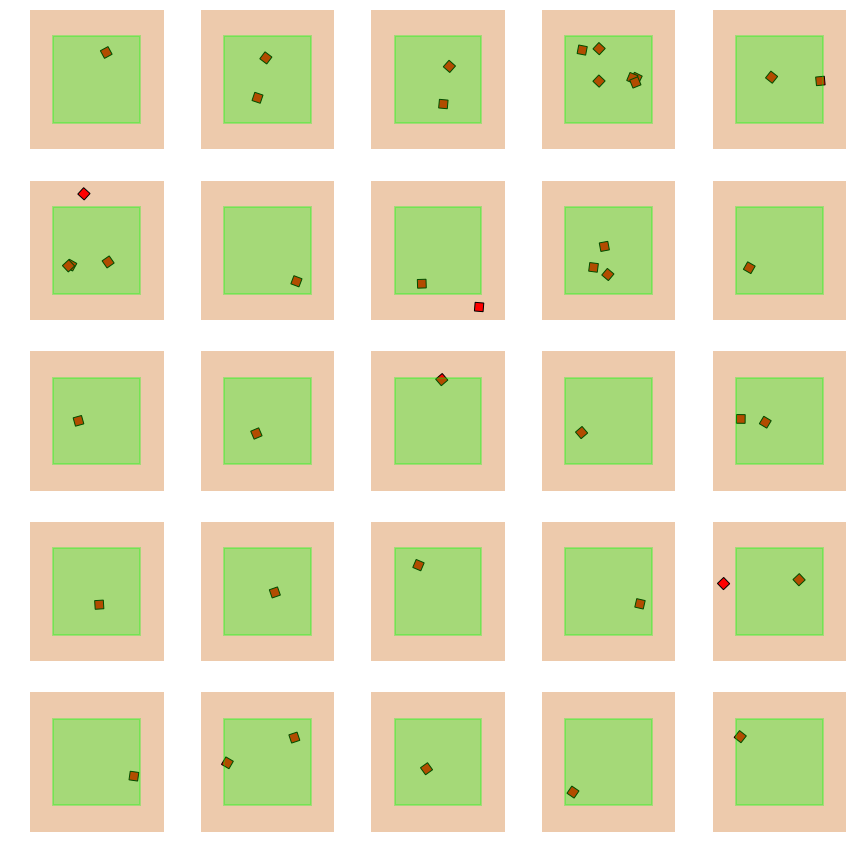

In [23]:
plt.figure().set_size_inches(12, 12)
print "Selection of environments from prior / generative model"
N = 5

for i in range(N):
    for j in range(N):
        plt.subplot(N, N, i*N+j+1)
        sample = poutine.condition(model, data=global_guide.median())()
        draw_environment(devectorize_environments(sample)[0], plt.gca())
        plt.grid(True)
plt.tight_layout()